# Select and Visualize ABCD Data
This notebook walks you through reading, filtering, and
visualizing ABCD data you downloaded in the previous step.
After this notebook is run you should be able to:
1. read data from a text file into python using pandas
1. select data using control flow (if statements and for loops)
1. filter data using pandas DataFrame methods.
1. store data in python data structures (lists, dictionaries, sets, and tuples)
1. write data to a file for future analysis using pandas
1. visualize data using seaborn and plotly

## Non-exhaustive list of concepts used in this notebook
You do not need a solid grasp of all these concepts to benefit
from running through this notebook, but we have provided a non-exhaustive
list of concepts used in this notebook if you wish to dig further into
these python concepts.
Each concept has a relevant article linked and an example of how that concept
is used in the notebook.

- python/programming language concepts
    - [libraries/importing](https://realpython.com/python-modules-packages/)
        - `import numpy as np`
    - [variables](https://realpython.com/python-variables/)
        - `data_elements = []`
    - [functions](https://realpython.com/defining-your-own-python-function/#functions-in-python)
        - `len(data_structures)`
- data structures
    - [lists/tuples](https://realpython.com/python-lists-tuples/)
        - `["subjectkey", "interview_date", "interview_age", "eventname", "sex"]`
    - [sets](https://realpython.com/python-sets/)
        - `{'18_month_follow_up_arm_1', 'baseline_year_1_arm_1', ..., 'screener_arm_1'}`
    - [pandas dataframes](https://realpython.com/pandas-dataframe/)
        - `pd.DataFrame(data_elements, columns=["element", "description", "structure"])`
- control structures
    - [if statements](https://realpython.com/python-conditional-statements/)
        - `if any(['eventname' == data_element for data_element in data_structure_df.columns.levels[0]]):
                ...`
    - [for loops](https://realpython.com/python-for-loop/)
        - `for data_structure, info in data_structures.items():
                ...`
- unix concepts
    - [globbing](https://swcarpentry.github.io/python-novice-inflammation/06-files/index.html)
        - `sorted(data_path.glob("*.txt"))`
    - [folders/directories](http://swcarpentry.github.io/shell-novice/02-filedir/index.html),
      [connection to python through pathlib](https://realpython.com/python-pathlib/)
        - `data_path = Path("/home/jovyan/ABCD3")`

- misc
    - [f-strings](https://realpython.com/python-f-strings/)
        - `f"/home/jovyan/ABCD3/{structure}.txt"`

### Import all libraries
By convention all libraries being used are read in at the top of a notebook/script.

In [137]:
import pandas as pd # to read/manipulate/write data from files
import numpy as np # to manipulate data/generate random numbers
import plotly.express as px # interactive visualizations
import seaborn as sns # static visualizations
import matplotlib.pyplot as plt # fine tune control over visualizations

from pathlib import Path # represent and interact with directories/folders in the operating system
from collections import namedtuple # structure data in an easy to consume way

import requests # retrieve data from an online source

### Gather all the data elements from all the txt files

The ABCD3 folder contains a number of tab-delimited text files with ABCD data.
We will first collect all of these files and then load them into pandas DataFrames
to compile and access the data.

Below we collect the files into a variable with the name `files`

In [146]:
# save directory we downloaded the ABCD data to `data_path`
data_path = Path("/home/jovyan/ABCD3")
# glob (match) all text files in the `data_path` directory
files = sorted(data_path.glob("*.txt"))

After collecting the files, we need to extract information about
the data structures and the data elements.
The data structures are the text file names (e.g., `abcd_abcls01`)
which indicate the type of data stored inside the text file.
The data elements are the column names inside the tab delimited
text file.

The data structure and data element names are condensed to make working
with them programmatically easier, but it is difficult for a human
to interpret what `abcd_abcls01` means.
So in addition to aggregating data structure and data element names
together, we are also collecting their metadata to have a human readable description
of their condensed names.

The data element metadata is located in the data structure files themselves
as the second row of the file, however, the data structure metadata was not downloaded
necessitating a query to the NDA website to retrieve the human readable
description of the data structure (using `requests`).

Finally, since we are only interested in the baseline measures, we need to keep track of
what names are given to each event in each of the data structures.

In [147]:
# We store the info in 4 different Python datatypes
data_elements = []
data_structures = {}
event_names = set()
StructureInfo = namedtuple("StructureInfo", field_names=["description", "eventnames"])

for text_file in files:
    # Extract data structure from filename
    data_structure = Path(text_file).name.split('.txt')[0]
    
    # Read the data structure and capture all the elements from the file
    # Note this could have been done using the data returned from the NDA API
    # We are using pandas to read both the first and second rows of the file as the header
    # Note: by convention dataframe variables contain `df` in the name.
    data_structure_df = pd.read_table(text_file, header=[0, 1], nrows=0)
    for data_element, metadata in data_structure_df.columns.values.tolist():
        data_elements.append([data_element, metadata, data_structure])

    
    # (Optional) Retrieve the eventnames in each structure. Some structures were only collected
    # at baseline while others were collected at specific or multiple timepoints
    events_in_structure = None
    if any(['eventname' == data_element for data_element in data_structure_df.columns.levels[0]]):
        # Here we are skipping the 2nd row of the file containing description using skiprows
        possible_event_names_df = pd.read_table(text_file, skiprows=[1], usecols=['eventname'])
        events_in_structure = possible_event_names_df.eventname.unique().tolist()
        event_names.update(events_in_structure)

    # (Optional) Retrieve the title for the structure using the NDA API
    rinfo = requests.get(f"https://nda.nih.gov/api/datadictionary/datastructure/{data_structure}").json()
    data_structures[data_structure] = StructureInfo(description=rinfo["title"] if "title" in rinfo else None,
                                                    eventnames=events_in_structure)

# Convert to a Pandas dataframe
data_elements_df = pd.DataFrame(data_elements, columns=["element", "description", "structure"])

We can use the .head method of any DataFrame to quickly look at the first few entries to make sure the DataFrame looks reasonable.

In [149]:
data_elements_df.head()

,element,description,structure
0,collection_id,collection_id,abcd_abcls01
1,abcd_abcls01_id,abcd_abcls01_id,abcd_abcls01
2,dataset_id,dataset_id,abcd_abcls01
3,subjectkey,The NDAR Global Unique Identifier (GUID) for r...,abcd_abcls01
4,src_subject_id,Subject ID how it's defined in lab/project,abcd_abcls01


#### Save data elements to a tab-separated file

In case we want to read/filter the data elements in 
another script and so we do not need to run the above code again,
we can save the data elements dataframe to a tab separated file (`tsv`).

<details>
<summary>Note on file extensions</summary>

**Note**: file extensions such as `tsv` and `txt` are markers for humans and certain computer programs to guess what the contents of a file are, but have no bearing on
what the contents of a file are.
If a file was renamed from `data.txt` to `data.tsv`,
the contents of the file remain the same.
    
</details>

In [150]:
data_elements_df.to_csv("data_elements.tsv", sep="\t", index=None)

When referencing the `shape` attribute, the first number is the number of rows and the second number is the number of columns.
There are _a lot_ of data elements, but keep in mind some data elements like `subjectkey`
are shared across data structures in order to match observations across data structures.


<details>
<summary>Note on shape</summary>

**Note**: `shape` is an attribute of the dataframe meaning we do not "call" shape (i.e., `shape()`), like
we would `head()`. `head` is a method for the DataFrame object

</details>

In [151]:
data_elements_df.shape

(75221, 3)

The number of data structures should match the number of txt files in the `data_path` directory.

In [152]:
# number of data structures
len(data_structures)

295

In [153]:
# number of txt files in the data_path directory
filenames = glob("/home/jovyan/ABCD3/*.txt")
nfiles = len(filenames)
print(nfiles)

295


`event_names` contains all the unique named timepoints represented across the data structures.

In [154]:
event_names

{'18_month_follow_up_arm_1',
 '1_year_follow_up_y_arm_1',
 '2_year_follow_up_y_arm_1',
 '30_month_follow_up_arm_1',
 '6_month_follow_up_arm_1',
 'baseline_year_1_arm_1',
 'screener_arm_1'}

#### Number of unique data elements
You should notice the number of unique data elements is less than
the number of rows in `data_elements_df`.
Why is that?

In [155]:
# unique data elements less than number of rows because some elements have multiple time points or perhaps there are siblings/family data
data_elements_df.element.unique().shape

(72013,)

#### Example row entry in data elements dataframe

In [156]:
data_elements_df.query("element == 'smri_vol_scs_amygdalalh'")

,element,description,structure
30612,smri_vol_scs_amygdalalh,Volume in mm^3 of ASEG ROI left-amygdala,abcd_smrip201


#### Use the following code block to quickly introspect variables in a structure
As opposed to above where we are asking information about a data element,
the following code block asks what data elements are within a data structure.

In [157]:
structure = 'abcd_mri01'  # 'abcd_betnet02'
example_structure_df = pd.read_table(data_path / f"{structure}.txt", header=[0, 1], nrows=0)
example_structure_df.columns.tolist()

[('collection_id', 'collection_id'),
 ('abcd_mri01_id', 'abcd_mri01_id'),
 ('dataset_id', 'dataset_id'),
 ('subjectkey',
  'The NDAR Global Unique Identifier (GUID) for research subject'),
 ('src_subject_id', "Subject ID how it's defined in lab/project"),
 ('interview_date',
  'Date on which the interview/genetic test/sampling/imaging/biospecimen was completed. MM/DD/YYYY'),
 ('interview_age',
  'Age in months at the time of the interview/test/sampling/imaging.'),
 ('sex', 'Sex of the subject'),
 ('eventname', 'The event name for which the data was collected'),
 ('mri_info_visitid', 'Visit name'),
 ('mri_info_manufacturer', 'Imaging device manufacturer'),
 ('mri_info_manufacturersmn', "Imaging device manufacturer's model name"),
 ('mri_info_deviceserialnumber',
  'Hashed version of imaging device serial number'),
 ('mri_info_magneticfieldstrength',
  'Magnetic field strength of imaging device in teslas'),
 ('mri_info_softwareversion', 'Imaging device software version'),
 ('mri_info_stu

#### Find all data structures that have baseline data
We are interested in the baseline measures and not all
the data structures have a measure for baseline.
All data structures with a baseline measure will be
printed for your convenience.

In [158]:
NOEVENTS = {}
for data_structure, info in data_structures.items():
    if info.eventnames:
        if 'baseline_year_1_arm_1' in info.eventnames:
            print(f"{data_structure}: {info.description}")
    else:
        NOEVENTS[data_structure] = info

abcd_ant01: ABCD Youth Anthropometrics Modified From PhenX (ANT)
abcd_asrs01: ABCD Parent Adult Self Report Scores Aseba (ASR)
abcd_auto_postqc01: Automated Post-Processing QC Metrics
abcd_betnet02: ABCD rsfMRI Gordon Network Correlations
abcd_bisbas01: ABCD Youth Behavioral Inhibition/Behavioral Approach System Scales Modified from PhenX (BIS/BAS)
abcd_bpmt01: ABCD Brief Problem Monitor-Teacher Form For Ages 6-18 (BPMT)
abcd_cbcl01: ABCD Parent Child Behavior Checklist Raw Scores Aseba (CBCL)
abcd_cbcls01: ABCD Parent Child Behavior Checklist Scores Aseba (CBCL)
abcd_crpf01: ABCD Parent Community Risk and Protective Factors (CRPF)
abcd_ddtidp101: ABCD dMRI DTI Destrieux Parcellations Part 1
abcd_ddtidp201: ABCD dMRI DTI Destrieux Parcellations Part 2
abcd_ddtifp101: ABCD dMRI DTI Full Destrieux Parcellation Part 1
abcd_ddtifp201: ABCD dMRI DTI Full Destrieux Parcellation Part 2
abcd_devhxss01: ABCD Summary Scores Developmental History
abcd_dmdtifp101: ABCD dMRI DTI Full Part 1
abcd_dm

Structures with no eventname or no baseline measure.
We cannot choose data elements from these data structures
for our analysis as they do not contain a baseline measure.

In [159]:
for data_structure, info in NOEVENTS.items():
    print(f"{data_structure}: {info.description}")

aurora01: Mobile Data
dhx01: ABCD Developmental History Questionnaire
fhxp201: ABCD Family History Assessment Part 2
fmriresults01: Processed MRI Data
guid_pseudoguid: None
omics_experiments: None
package_info: None
pps01: ABCD Prodromal Psychosis Scale
sph01: ABCD Pubertal Hormone Saliva
srpf01: ABCD School Risk and Protective Factors Survey


Below are the data elements we require to answer our question of interest
(change these variables to match your research question of interest)
Be sure to select a mix of categorical and continuous measures and to keep
the `common` variables.

In [160]:
common = ["subjectkey", "interview_date", "interview_age", "eventname", "sex"]
demographic = ["site_id_l", 'interview_age', "anthroheightcalc", "anthroweightcalc", 'neighborhood_crime_y']
clinical = ['ksads_ptsd_raw_763_p', 'ksads_ptsd_raw_766_p', 'fes_y_ss_fc_pr']
behavioral = [] 
cognitive = []
imaging = ["rsfmri_c_ngd_meanmotion", 'rsfmri_c_ngd_sa_ngd_cgc', 'rsfmri_c_ngd_sa_ngd_ca', 'rsfmri_c_ngd_sa_ngd_dt', 'rsfmri_c_ngd_sa_ngd_dla', 'rsfmri_c_ngd_sa_ngd_fo', 'rsfmri_c_ngd_sa_ngd_rspltp', 'rsfmri_c_ngd_sa_ngd_vta']

data_elements_of_interest = demographic + clinical + behavioral + cognitive + imaging

#### Find the data structures that contain the data elements

The `data_elements_of_interest` above tell us what data elements we wish to analyze,
but they do not provide information about which data structures the data elements are located.
But do not fret, we created `data_elements_df` to match data elements with their respective data structures,
giving us the ability to find the data structure associated with each data element of interest.

In [161]:
structures2read = {}
for element in data_elements_of_interest:
    item = data_elements_df.query(f"element == '{element}'").structure.values[0]
    if item not in structures2read:
        structures2read[item] = []
    structures2read[item].append(element)
structures2read

{'abcd_lt01': ['site_id_l'],
 'abcd_abcls01': ['interview_age'],
 'abcd_ant01': ['anthroheightcalc', 'anthroweightcalc'],
 'abcd_nsc01': ['neighborhood_crime_y'],
 'abcd_ptsd01': ['ksads_ptsd_raw_763_p', 'ksads_ptsd_raw_766_p'],
 'abcd_sscey01': ['fes_y_ss_fc_pr'],
 'abcd_betnet02': ['rsfmri_c_ngd_meanmotion',
  'rsfmri_c_ngd_sa_ngd_cgc',
  'rsfmri_c_ngd_sa_ngd_ca',
  'rsfmri_c_ngd_sa_ngd_dt',
  'rsfmri_c_ngd_sa_ngd_dla',
  'rsfmri_c_ngd_sa_ngd_fo',
  'rsfmri_c_ngd_sa_ngd_rspltp',
  'rsfmri_c_ngd_sa_ngd_vta']}

#### Construct a new table of data containing the observations from the data elements

Now we have the data structures that contain the data elements of interest in `structures2read`,
a dictionary whose keys are the data structures and whose values are the data elements of interest
within that data structure.
Below is an example of loading one data structure into python with the data elements of interest.

In [162]:
# Read data from one structure (first data element is 0)
example_df = pd.read_table(data_path / f"{list(structures2read)[0]}.txt", skiprows=[1], low_memory=False,
                  usecols=common + structures2read[list(structures2read)[0]])
example_df.head()

,subjectkey,interview_date,interview_age,sex,eventname,site_id_l
0,NDAR_INV007W6H7B,02/21/2017,126,M,baseline_year_1_arm_1,site22
1,NDAR_INV00BD7VDC,04/24/2019,123,M,1_year_follow_up_y_arm_1,site07
2,NDAR_INV00CY2MDM,01/16/2018,135,M,6_month_follow_up_arm_1,site20
3,NDAR_INV00J52GPG,09/11/2019,122,M,1_year_follow_up_y_arm_1,site17
4,NDAR_INV00LH735Y,06/26/2019,126,M,18_month_follow_up_arm_1,site03


However, we need to load all the data structures into one dataframe so we can have all the data elements
of interest together.
Below is the code that combines all the data elements into one DataFrame

In [163]:
all_df = None
for structure, elements in structures2read.items():
    data_structure_filtered_df = pd.read_table(data_path / f"{structure}.txt", skiprows=[1], low_memory=False, usecols=common + elements)
    data_structure_filtered_df = data_structure_filtered_df.query("eventname == 'baseline_year_1_arm_1'")
    if all_df is None:
        all_df =  data_structure_filtered_df[["subjectkey", "interview_date", "interview_age", "sex"] + elements]
    else:
        all_df = all_df.merge( data_structure_filtered_df[['subjectkey'] + elements], how='outer')

Make sure the resulting dataframe looks sensible

In [164]:
all_df.head()

,subjectkey,interview_date,interview_age,sex,site_id_l,anthroheightcalc,anthroweightcalc,neighborhood_crime_y,ksads_ptsd_raw_763_p,ksads_ptsd_raw_766_p,fes_y_ss_fc_pr,rsfmri_c_ngd_meanmotion,rsfmri_c_ngd_sa_ngd_cgc,rsfmri_c_ngd_sa_ngd_ca,rsfmri_c_ngd_sa_ngd_dt,rsfmri_c_ngd_sa_ngd_dla,rsfmri_c_ngd_sa_ngd_fo,rsfmri_c_ngd_sa_ngd_rspltp,rsfmri_c_ngd_sa_ngd_vta
0,NDAR_INV007W6H7B,02/21/2017,126,M,site22,56.50,82.8,4.0,0.0,0.0,0.0,0.038432,0.146978,0.145803,-0.003974,-0.006031,0.115372,-0.149750,0.010642
1,NDAR_INV00LH735Y,01/29/2018,109,M,site03,52.00,80.0,5.0,0.0,0.0,0.0,0.075550,0.165857,0.287123,0.031217,-0.014402,0.107300,-0.127307,0.070095
2,NDAR_INV014RTM1V,05/02/2017,115,M,site17,55.35,89.2,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NDAR_INV0182J779,06/25/2018,111,F,site06,54.00,74.0,5.0,0.0,0.0,0.0,1.982831,0.237304,-0.580325,0.215719,-0.231733,0.166860,-0.667481,0.317699
4,NDAR_INV01NAYMZH,08/09/2017,129,M,site16,60.50,91.0,5.0,0.0,0.0,2.0,0.100919,0.053189,0.166478,0.092259,-0.006801,0.039012,0.069942,0.027299


Check that each participant has one and only one observation.

In [165]:
all_df.shape, all_df.subjectkey.unique().shape

((11878, 19), (11878,))

See the duplicated entries.

In [166]:
all_df[all_df.duplicated('subjectkey', keep=False)]

,subjectkey,interview_date,interview_age,sex,site_id_l,anthroheightcalc,anthroweightcalc,neighborhood_crime_y,ksads_ptsd_raw_763_p,ksads_ptsd_raw_766_p,fes_y_ss_fc_pr,rsfmri_c_ngd_meanmotion,rsfmri_c_ngd_sa_ngd_cgc,rsfmri_c_ngd_sa_ngd_ca,rsfmri_c_ngd_sa_ngd_dt,rsfmri_c_ngd_sa_ngd_dla,rsfmri_c_ngd_sa_ngd_fo,rsfmri_c_ngd_sa_ngd_rspltp,rsfmri_c_ngd_sa_ngd_vta


If duplicated entries have `n/a`'s, drop those rows,
then each participant should have one and only one observation.

In [167]:
all_df = all_df.dropna()
all_df.shape, all_df.subjectkey.unique().shape

((10903, 19), (10903,))

#### Choose a random subset of participants

Every time your run the following code, a random set of 1000 participants is chosen. How would you alter this code to choose the same N participants each time?

<details>
<summary>Possible solution</summary>

rng = np.random.default_rng(seed=123)
rng.choice(np.arange(all_df.shape[0]), replace=False, size=N)

source = https://numpy.org/doc/stable/reference/random/generator.html
</details>


In [168]:
# select a random 1000 participants every time the code is run
N = 1000
indices = np.random.choice(np.arange(all_df.shape[0]), replace=False, size=N)
subset_df = all_df.iloc[indices, :]
subset_df.shape

(1000, 19)

In [169]:
# select the same 1000 participants every time the code is run
N = 1000
rng = np.random.default_rng(seed=123) # seed can be any number
indices2 = rng.choice(np.arange(all_df.shape[0]), replace=False, size=N)
subset_df2 = all_df.iloc[indices, :]
subset_df2.shape

(1000, 19)

The `.describe` method of a dataframe provides a summary of the data
for each column.

#### Write the subset_df to a file named "my_dataset.tsv"
<details>
<summary>Hint</summary>
Look earlier in the notebook on how the `.to_csv` method was used.
</details>

In [170]:
subset_df.to_csv("subset_df.tsv", sep="\t", index=None)

### Display a linear regression between two variables for two groups
After filtering and subsetting our data, a common next step is to visualize
our variables of interest.

Choose a brain imaging variable and a clinical variable that are both continuous. Now plot a relation between these two variables grouped by sex of the participants.

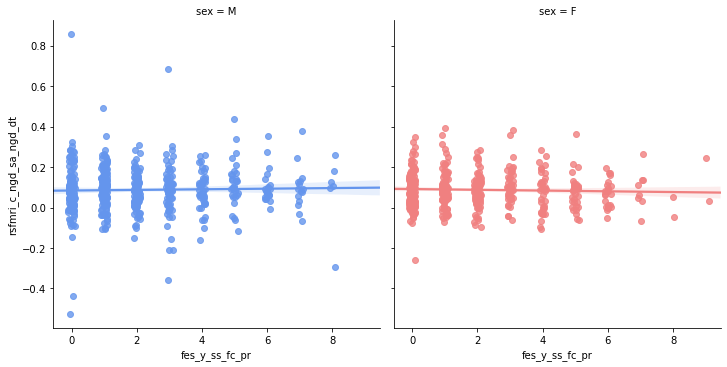

In [171]:
# Make a custom palette with gendered colors
# Note: this is equivalent to {"M": "#6495ED", "F": "#F08080"}
pal = dict(M="#6495ED", F="#F08080")

# Show correlation as a function of family conflict and sex
g = sns.lmplot(x='fes_y_ss_fc_pr', y='rsfmri_c_ngd_sa_ngd_dt', col="sex", hue="sex", data=subset_df,
               palette=pal, y_jitter=.04, x_jitter=.1, logistic=False, truncate=False)

### Display relations between 4 variables color coded by a categorical variable

Choose sex as your group variable and one variable from each of the four categories
(demographic, clinical, behavioral, imaging)

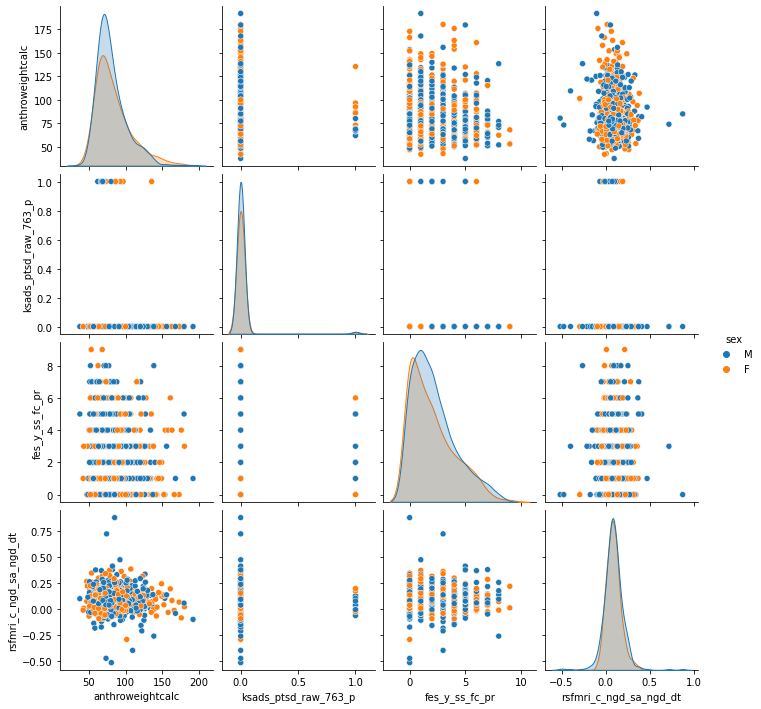

In [172]:
sns.pairplot(subset_df, hue="sex", vars=["anthroweightcalc", 'ksads_ptsd_raw_763_p', 'fes_y_ss_fc_pr', "rsfmri_c_ngd_sa_ngd_dt"]);

### Create an interactive plot that allows viewing many variables

Can you plot all 20 variables simultaneously?
([pandas.plotting.parallel_coordinates — pandas 1.1.4 documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.parallel_coordinates.html))
For an interactive plot you can use plotly
([Parallel Coordinates Plot | Python](https://plotly.com/python/parallel-coordinates-plot/))
in the notebook.

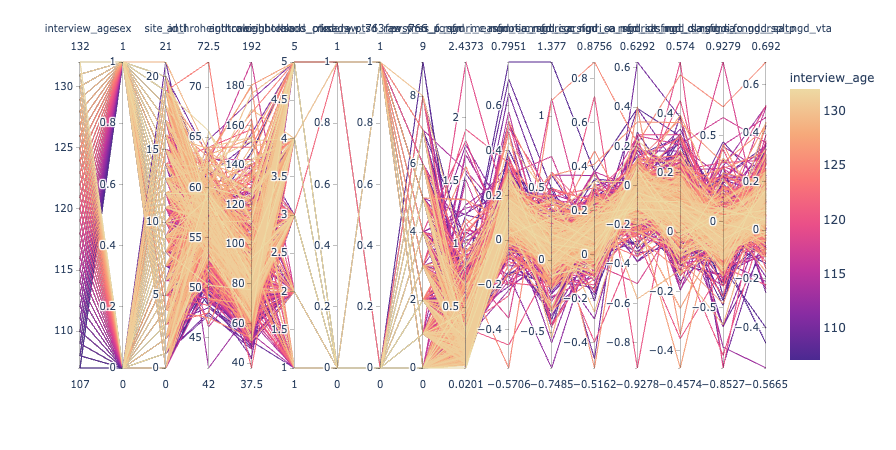

<Figure size 2160x432 with 0 Axes>

In [185]:
plt.figure(figsize=(30, 6))
# Create an interactive parallel coordinate plot
subset_df_numerical = subset_df.copy()
subset_df_numerical.sex = subset_df.sex.astype("category").cat.codes
subset_df_numerical.site_id_l = subset_df.site_id_l.astype("category").cat.codes
fig = px.parallel_coordinates(subset_df_numerical, color="interview_age", 
                              dimensions=["interview_age", "sex"] + data_elements_of_interest,
                              color_continuous_scale=px.colors.sequential.Agsunset,)
                              #color_continuous_midpoint=2)
fig.show()

### Display effects of two categories on a continuous variable

For this exercise you will need two categorical variables and one continuous variable.
You are going to show how the continuous variable behaves as a function of the categorical variables.

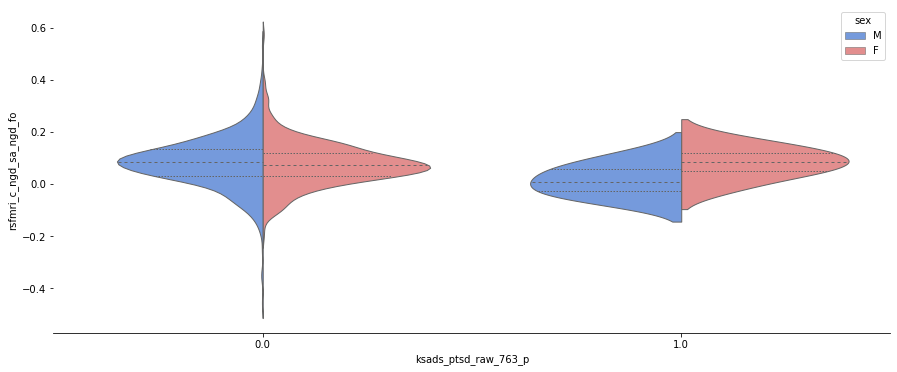

In [210]:
plt.figure(figsize=(15, 6))
sns.violinplot(data=subset_df, x="ksads_ptsd_raw_763_p", y="rsfmri_c_ngd_sa_ngd_fo", hue="sex",
               split=True, inner="quart", linewidth=1,
               palette={"M": "#6495ED", "F": "#F08080"})
sns.despine(left=True)

You have been introduced to the enormity of the ABCD dataset through python,
but with selecting, filtering, and visualizing data, you've made the data
manageable (and perhaps even enjoyable?) to work with.
We will continue working with subset of data selected in future notebooks,
but for now you can reflect on what you've learned and you can go back and
play with different variables.